In [1]:
DATASET = 'full'
OUTNAME = 'SAGE_scales' #'SAGE'
NPERMS = 10
DIFFICULTY_BINS = 10

In [2]:
import sys
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
import gc
from sklearn.manifold import TSNE
import seaborn as sns
from cluster_utils import evaluate_items
from vis_utils import (visualize_students, visualize_edges_age, visualize_edges, visualize_items, myresults, FIGSIZE,
CLUSTER_LABELS,  AGE_THR, DPI, CPU_Unpickler, plot_clustering, FONTSCALE)

sns.set_theme(context='talk', style='white', font_scale=FONTSCALE)

FILENAME = f'{OUTNAME}_{DATASET}'
EQUAL_AXES=False
MINSAMPLES = 10 #if DATASET in ['matrix', 'topic'] else 10

RELOAD = False

In [3]:
FILENAME

'SAGE_scales_full'

In [4]:
torch.cuda.empty_cache()
device = 'cpu'
model = torch.load(f'./results/{FILENAME}.pth.tar', map_location=torch.device('cpu'))

In [5]:
with open(f'./results/{FILENAME}_aux_data.pkl', 'rb') as handle:
    aux_data = CPU_Unpickler(handle).load()
    
(df, df_student, df_item, df_edge, 
            train_losses, #test_losses, test_aucs,
            train_edge_indices, val_edge_indices, test_edge_indices, 
            data, train_data, val_data, test_data,
            unique_scales, unique_domains, unique_matdiff, 
            DATA_FILE) = aux_data
print(df_item.shape)

try:
    # if IRT data exists, take item parameters
    with open(f'./results/IRT_{DATASET}_aux_data_IRT1.pkl', 'rb') as handle:
        aux_data = CPU_Unpickler(handle).load()

    (_, _, df_item, *_) = aux_data
except:
    print('IRT1 not found')
    
print(df_item.shape)

(35087, 8)
(35087, 11)


In [6]:
if RELOAD:
    df = load_data_heterogeneous(DATA_FILE)
    data, df_student, df_item, df_edge = create_data_object_heterogeneous(df)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

2029601


In [8]:
print(data)

HeteroData(
  student={
    node_id=[91677],
    x=[91677, 2],
  },
  item={
    node_id=[35087],
    x=[35087, 11],
  },
  (student, responds, item)={
    edge_index=[2, 33767508],
    edge_attr=[33767508, 2],
    y=[33767508],
  },
  (item, rev_responds, student)={ edge_index=[2, 33767508] }
)


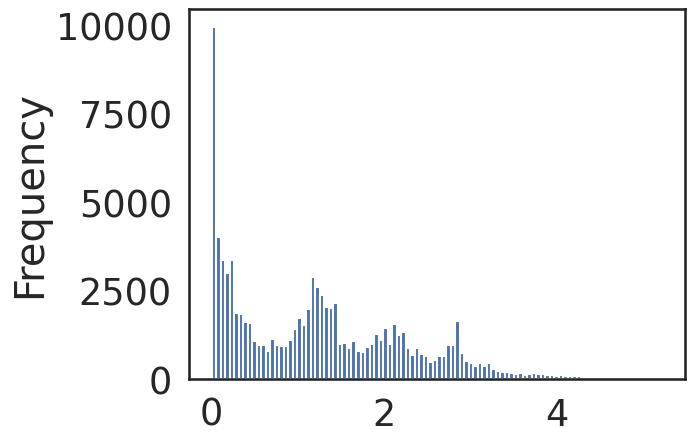

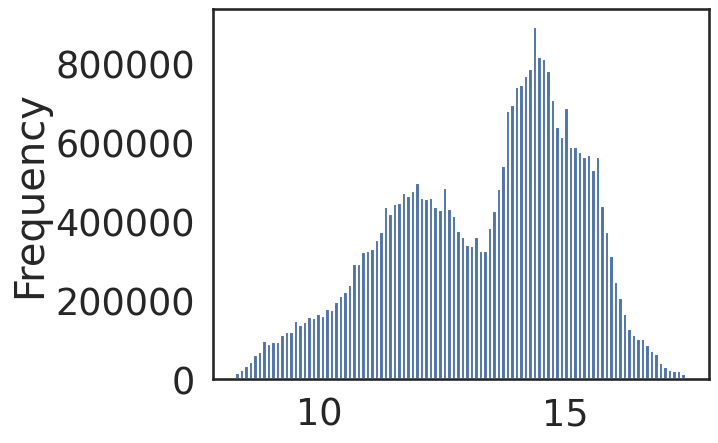

In [9]:
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())
fig = plt.figure()
age_ranges.plot.hist(bins=100)
plt.show()

fig = plt.figure()
df.age.plot.hist(bins=100)
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())

plt.show()

236.0

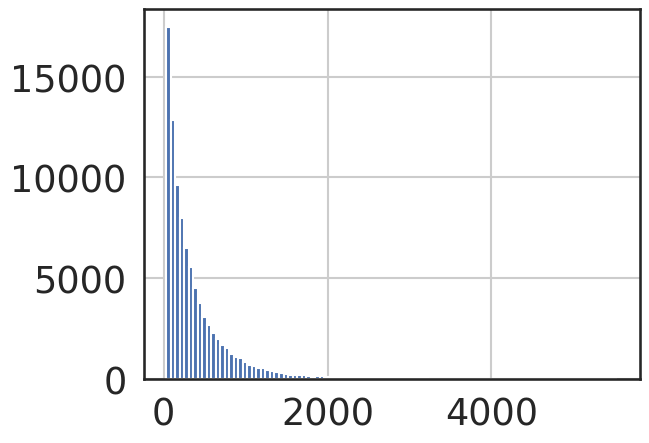

In [10]:
# different items per student
df.groupby(['studentId']).code.nunique().hist(bins=100)
df.groupby(['studentId']).code.nunique().median()


10.0

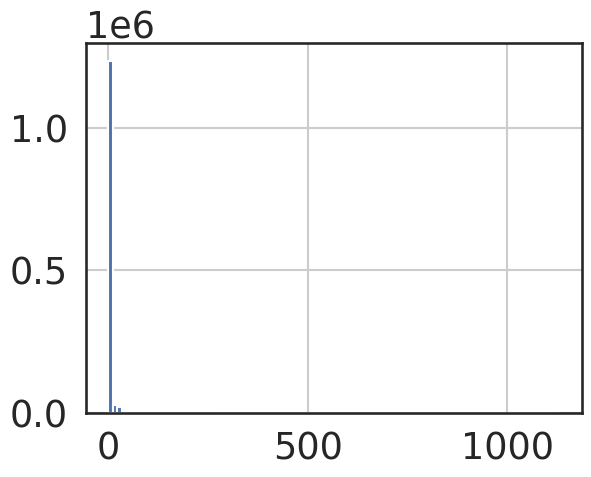

In [11]:
df.groupby(['assessmentId']).code.nunique().hist(bins=100)
df.groupby(['assessmentId']).code.nunique().median()

In [12]:
age_ranges.mean()

1.2189035417825627

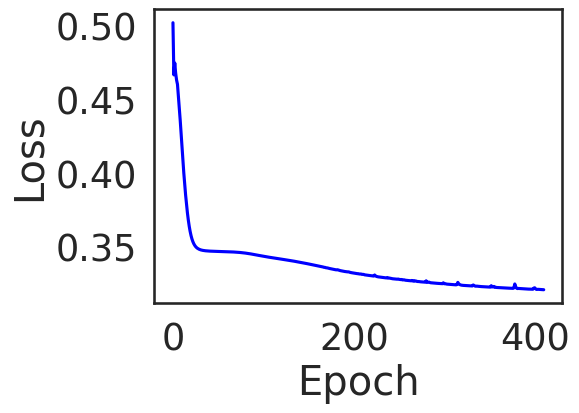

In [13]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_losses.png', dpi=DPI)

In [14]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,school_postcode,canton,school_code,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
1,0,1,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
2,0,2,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
3,0,3,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,4057,Basel-Stadt,04-052,1.083005,1.851849,2,1.08,,,f
4,0,4,1.0,0.0,fles,F.2.A.1.b.3,-0.49488,Berichte,NaN,NaN,...,4057,Basel-Stadt,04-052,0.657010,2.727266,3,1.10,,,f


df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)

df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()


In [15]:
from scipy.stats import pearsonr
pearsonr(df_item['IRT1_difficulty'], df_item['IRT1_discrimination_transf'])

PearsonRResult(statistic=-0.2198114444661636, pvalue=0.0)

plot_clustering('scalexdifficulty', 'matrix', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
plot_clustering('scalexdifficulty', 'topic', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)


if DATASET in ['matrix', 'topic']:
    sys.exit()

In [16]:
myresults.output_stats()

matrix
MA.2.A.2.f.1    38
MA.2.B.1.e      25
MA.2.C.3.e.1    25
MA.2.A.3.j.1    25
MA.2.C.3.f.1    24
                ..
MA.2.A.2.g.1     1
MA.2.A.3.i       1
MA.2.C.4.f       1
MA.2.C.3.d       1
MA.2.C.3.e       1
Name: count, Length: 65, dtype: int64
matrix
MA.2.A.2.f.1    38
MA.2.B.1.e      25
MA.2.C.3.e.1    25
MA.2.A.3.j.1    25
Name: count, dtype: int64


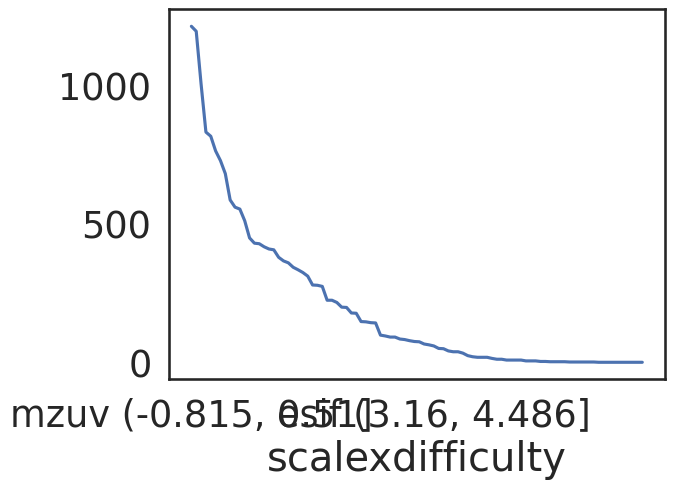

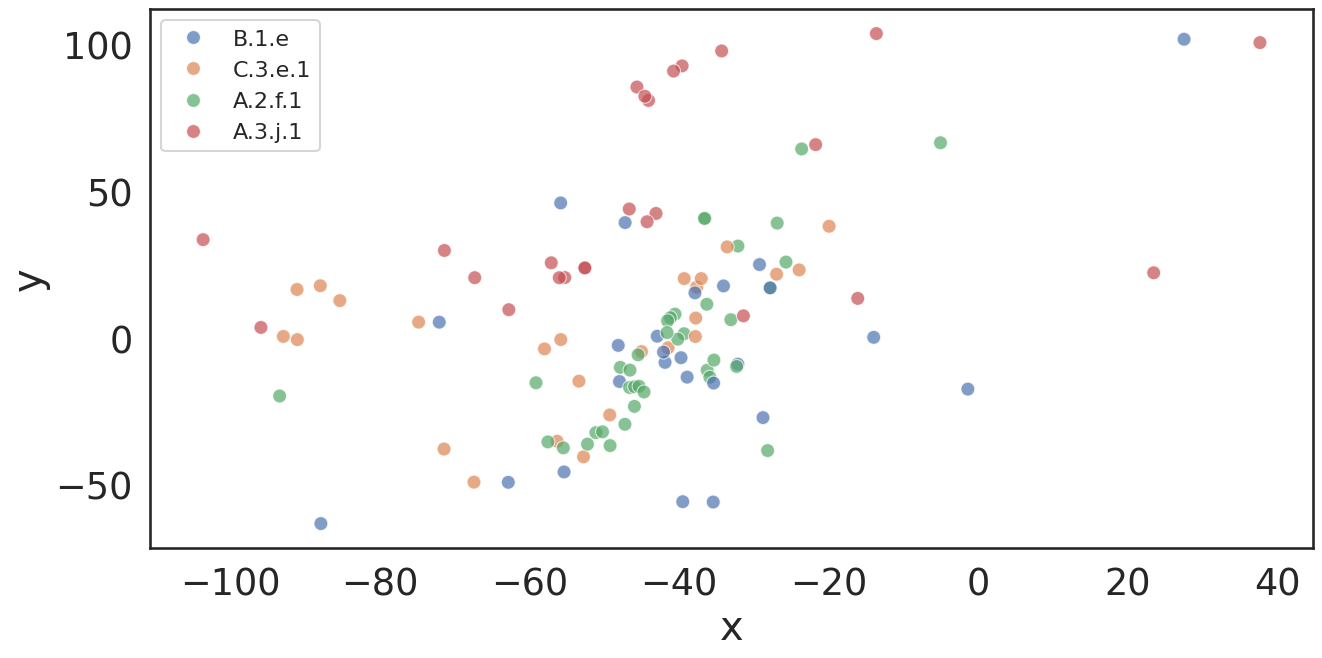

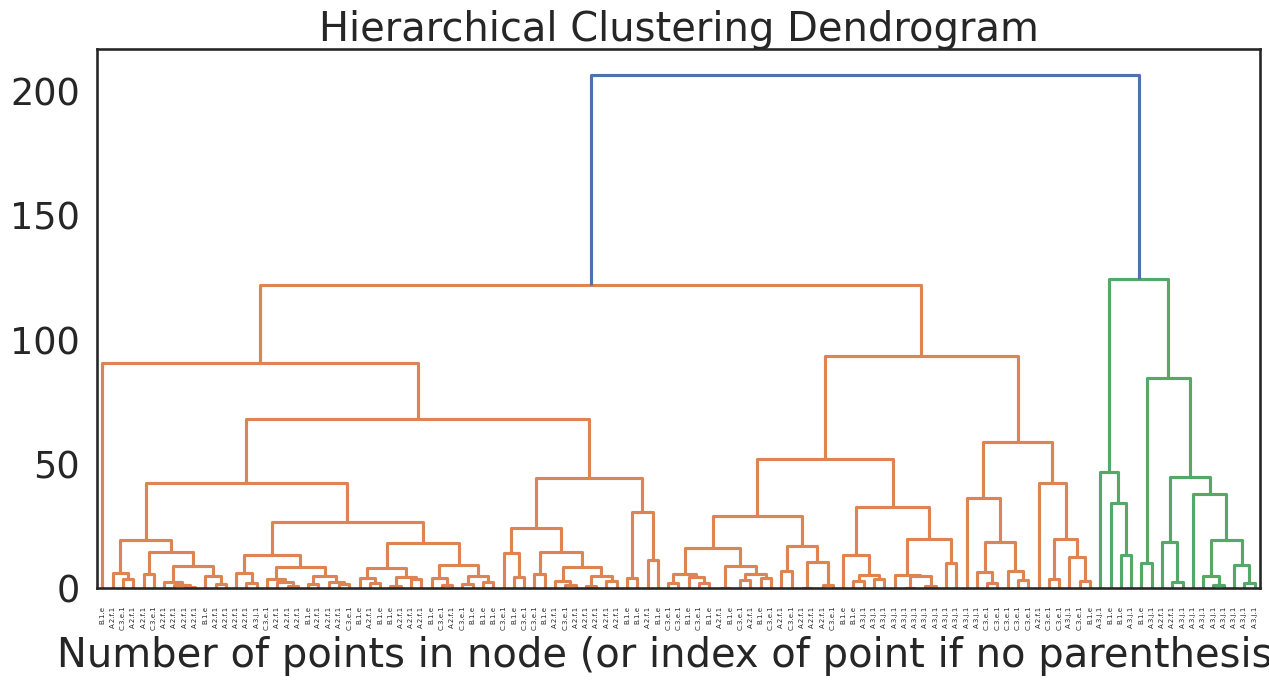

matrix
MA.1.A.4.k.1    43
MA.1.B.1.j.2    40
MA.1.B.1.h.2    40
MA.1.A.3.i.2    32
MA.1.C.1.c.1    32
                ..
MA.1.A.3.c       1
MA.1.A.2.c.1     1
MA.1.A.2.c.2     1
MA.1.A.1.f.1     1
MA.1.C.2.d.1     1
Name: count, Length: 110, dtype: int64
matrix
MA.1.A.4.k.1    43
MA.1.B.1.h.2    40
MA.1.B.1.j.2    40
MA.1.A.3.i.2    32
Name: count, dtype: int64


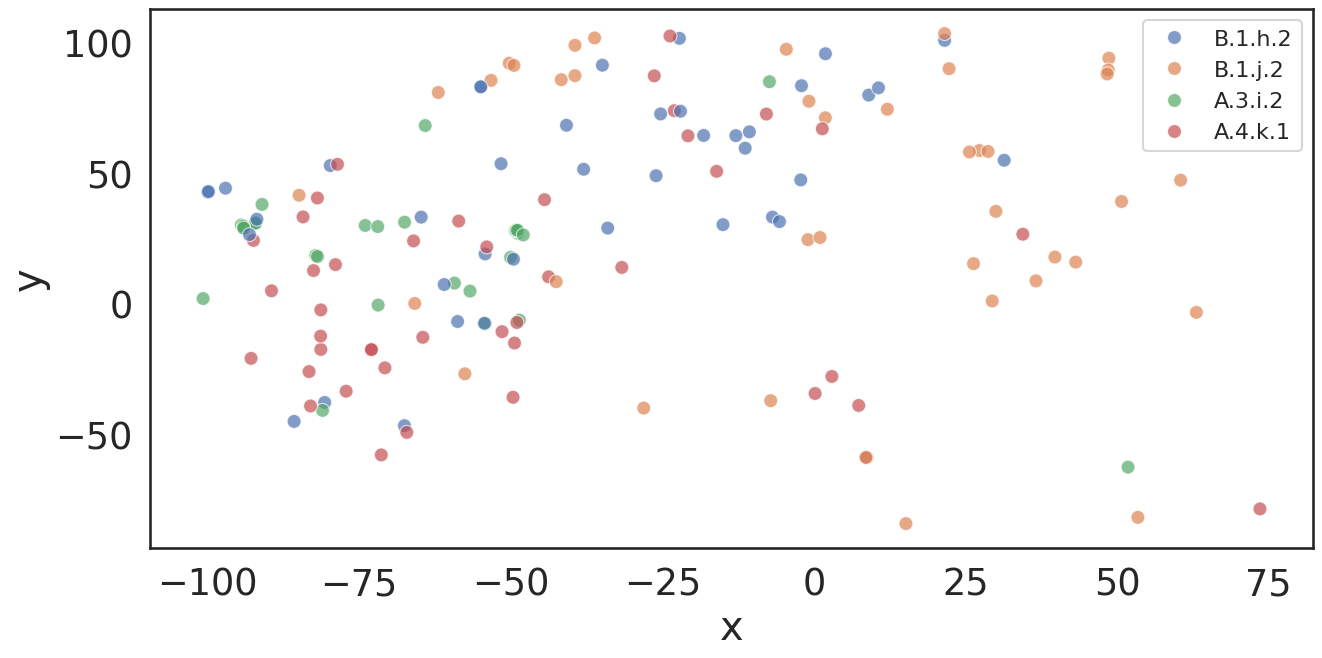

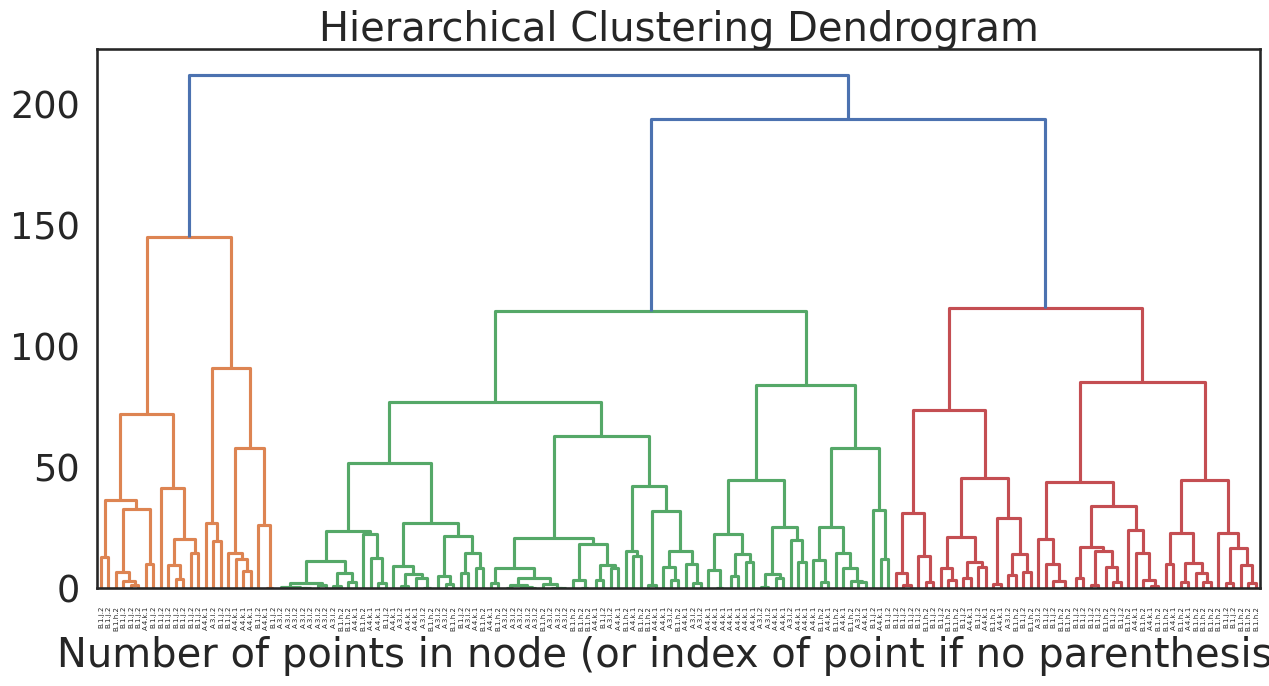

matrix
MA.2.B.1.f.1    45
MA.2.A.2.d.1    35
MA.2.A.3.c      25
MA.2.C.3.d.2    23
MA.2.C.4.b      23
                ..
MA.2.A.3.e       1
MA.2.C.4.g       1
MA.2.A.2.f       1
MA.2.B.1.d       1
MA.2.A.3.i.2     1
Name: count, Length: 62, dtype: int64
matrix
MA.2.B.1.f.1    45
MA.2.A.2.d.1    35
MA.2.A.3.c      25
MA.2.C.3.d.2    23
Name: count, dtype: int64


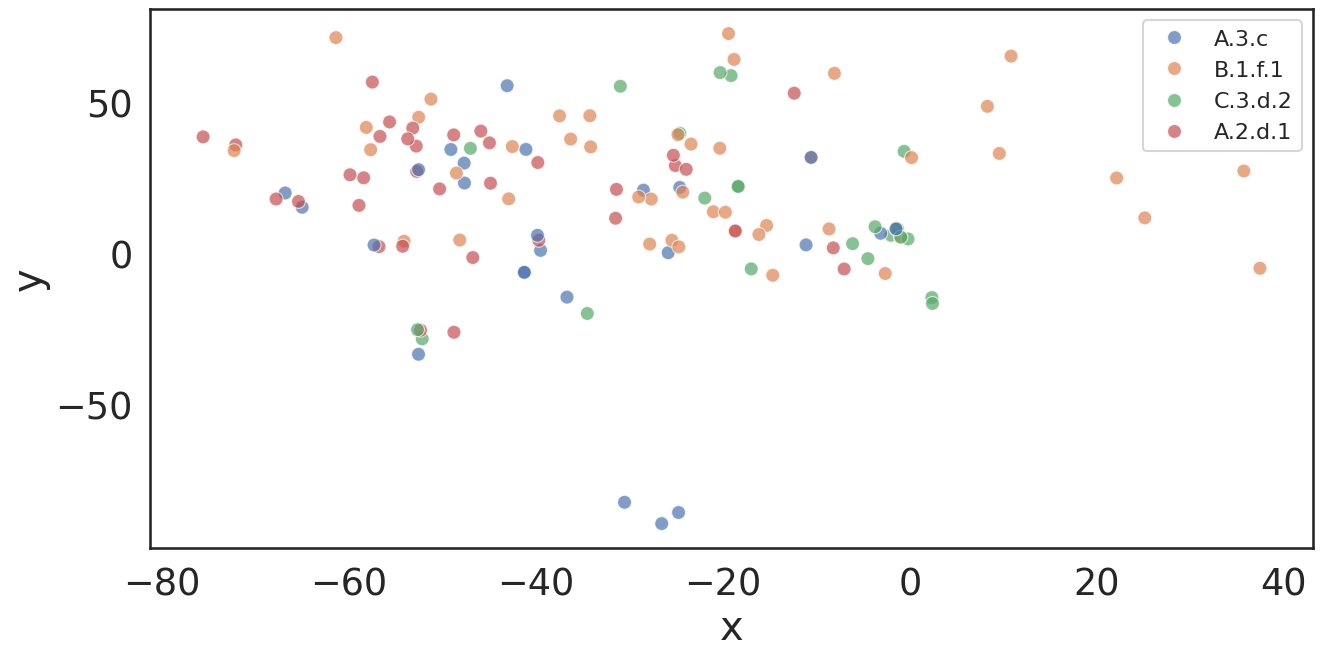

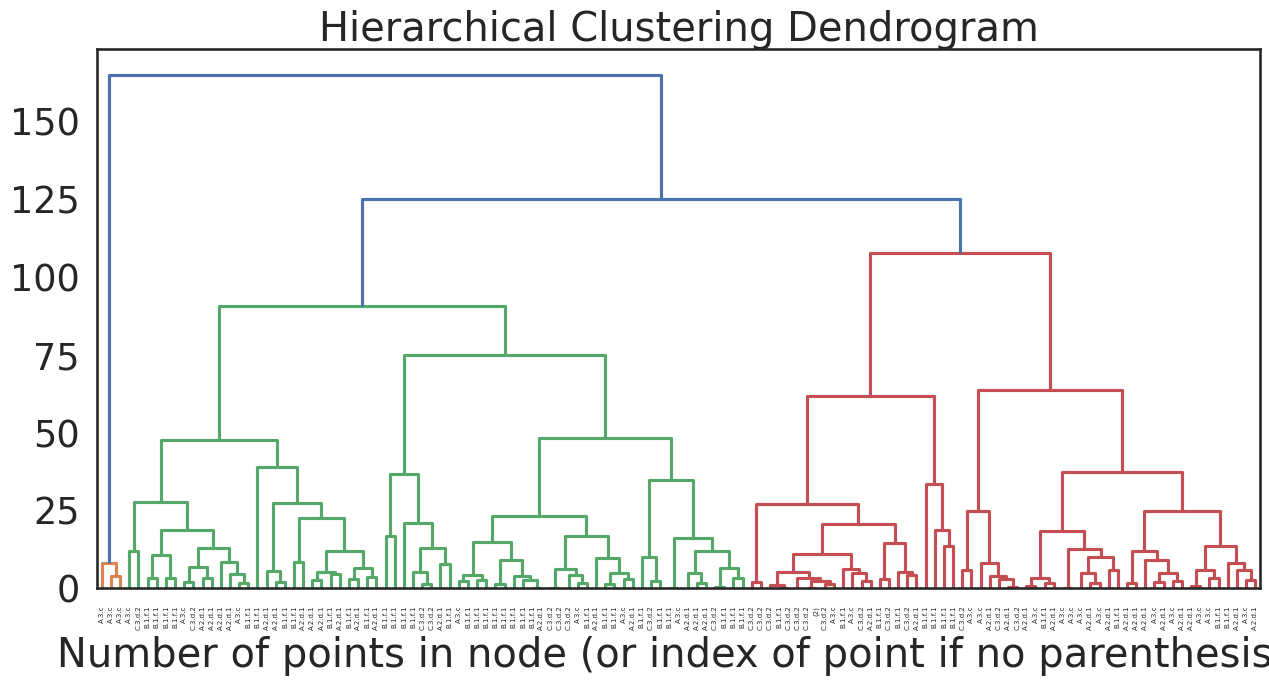

matrix
D.5.D.1.f.4    35
D.5.E.1.g.2    32
D.5.E.1.g      30
D.5.D.1.d.3    23
D.5.D.1.f.1    21
D.5.D.1.c.1    21
D.5.D.1.g.2    21
D.5.D.1.c.2    20
D.5.D.1.f      16
D.5.E.1.f      16
D.5.D.1.e.3    15
D.5.E.1.f.1    14
D.5.D.1.g.1    13
D.5.D.1.e.4    13
D.5.E.1.d.3    12
D.5.E.1.e.1    11
D.5.D.1.f.3    10
D.5.D.1.f.5     9
D.5.E.1.c.2     9
D.5.D.1.e.1     8
D.5.E.1.c.4     8
D.5.D.1.g.3     8
D.5.D.1.e       7
D.5.E.1.e       7
D.5.D.1.f.2     5
D.5.D.1.b.4     3
D.5.E.1.b.3     3
D.5.D.1.d.1     3
D.5.D.1.c       3
D.5.D.1.c.3     3
D.5.D.1.d.2     3
D.5.D.1.g.4     2
D.5.D.1.e.2     2
D.5.D.1.c.4     2
D.5.D.1.c.5     2
D.5.E.1.d       2
D.5.D.1.f.6     1
D.5.D.1.b.3     1
D.5.D.1.d.4     1
D.5.E.1.c       1
D.5.D.1.g       1
Name: count, dtype: int64
matrix
D.5.D.1.f.4    35
D.5.E.1.g.2    32
D.5.E.1.g      30
D.5.D.1.d.3    23
Name: count, dtype: int64


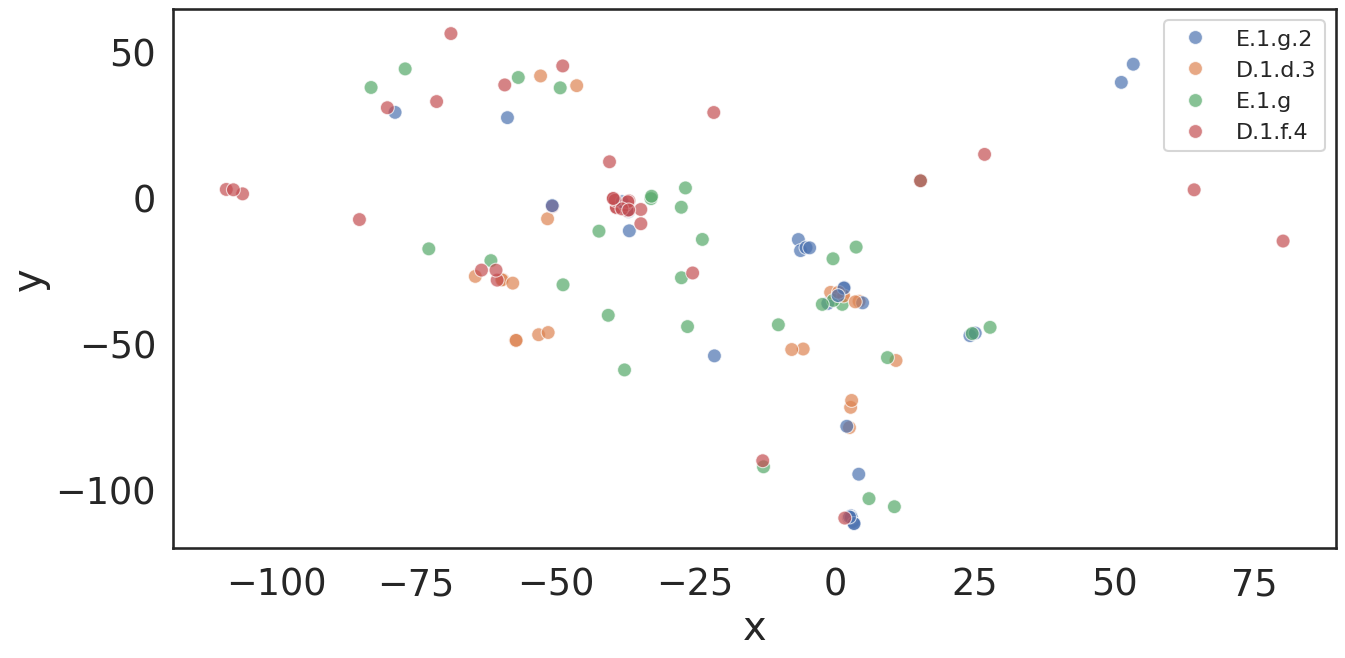

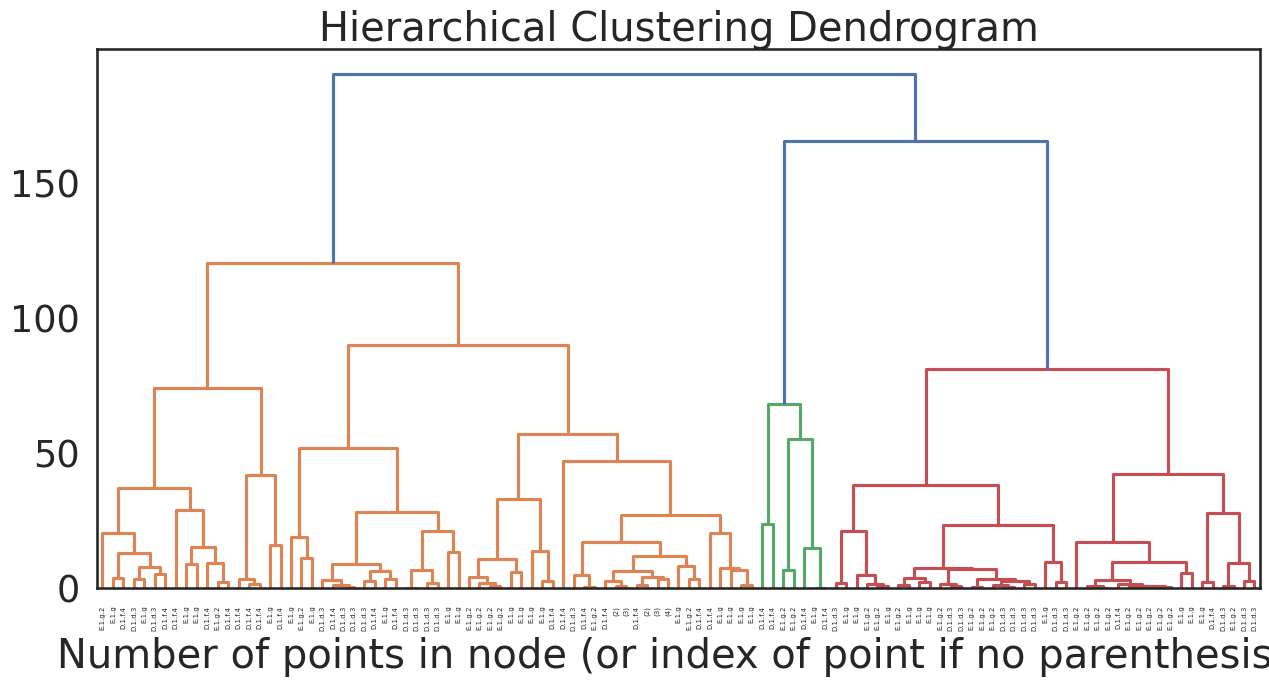

In [17]:
minlevels = 8
MINSAMPLES = 20
from cluster_utils import compute_clustering_indices
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

dimred = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
#dimred = PCA(whiten=False)

df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                         
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)
df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()


grouping_variable, target_variable = 'scalexdifficulty', 'matrix'
scores_dict = {'CH': [], 'DB':[], 'N_LEVELS':[], 'N_SAMPLES':[]}
scores = compute_clustering_indices(model, train_data, df_item.copy(), device, grouping_variable, 
                                        target_variable, shuffle=False, seed=0, minsamples=MINSAMPLES)
[ scores_dict[key].append(scores[key]) for key in scores_dict]

scores_df = pd.DataFrame(scores_dict['DB'])        
scores_df = pd.melt(scores_df, value_name='index', var_name=grouping_variable).sort_values('index', ascending=False)

scores_df['N_LEVELS'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_LEVELS'][0][x])
scores_df['N_SAMPLES'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_SAMPLES'][0][x])

scores_df = scores_df.loc[scores_df['N_LEVELS'] >= minlevels]


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
def plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, scores_df, k=0):
    df_item_ = df_item.reset_index().drop(columns='index')

    df_item_sub = df_item_.loc[df_item_[grouping_variable] == scores_df.iloc[k][grouping_variable]]
    
    # look only at those with a minimum of samples
    tab = df_item_sub[target_variable].value_counts()
    print(tab)
    #ind = tab[tab >= minsamples].index
    ind = tab[:4].index
    df_item_sub = df_item_sub.loc[df_item_sub[target_variable].isin(ind).values]
    if target_variable == 'matrix':
        df_item_sub['labels'] = df_item_sub[target_variable].apply(lambda x: '.'.join(x.split('.')[2:]))
    else:
        df_item_sub['labels'] = df_item_sub[target_variable]
    print(df_item_sub[target_variable].value_counts())
    data = data.to(device)

    z_dict = model.get_embeddings(data, encoded=True)
    embedding = z_dict['item'].detach().cpu().numpy()
    #dimred.fit(embedding)
    #low_dim = dimred.transform(embedding)

    low_dim = dimred.fit_transform(embedding)
    low_dim = low_dim[df_item_sub.index, :]

    X = df_item_sub #.loc[select, :]

    #X['domain'] = X['domain'].apply(lambda x: DOMAIN_LABELS[x])

    X['x'] = low_dim[:, 0]
    X['y'] = low_dim[:, 1]
     #   X['z'] = low_dim[:, 2]

    fig = plt.figure(figsize=(15, 7))
    axes = sns.scatterplot(data=X, x='x', y='y', hue='labels', s=100, alpha=0.7) 
    axes.legend(prop = { 'size': 16 })
    plt.show()

    clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
    clustering.fit(low_dim)

    fig = plt.figure(figsize=(15, 7))
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram

    plot_dendrogram(clustering, truncate_mode="level", p=10, labels=df_item_sub['labels'].values)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    
for k in range(4):
    plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, scores_df, k=k)


In [18]:
scores_df


,scalexdifficulty,index,N_LEVELS,N_SAMPLES
32,"mfur (0.51, 1.835]",0.174684,8,201
6,"mzuv (0.51, 1.835]",0.165481,16,455
29,"mfur (-0.815, 0.51]",0.163033,8,218
7,"dsif (1.835, 3.16]",0.162706,8,203
30,"dles (-0.815, 0.51]",0.146925,13,514
10,"mzuv (-0.815, 0.51]",0.139415,21,601
41,"mgfz (-0.815, 0.51]",0.134289,9,292
19,"dsif (-2.141, -0.815]",0.130647,10,462
48,"mgfz (0.51, 1.835]",0.125034,15,423
17,"dsif (-0.815, 0.51]",0.110507,18,965


# represent embeddings before and after the GNN encoder
visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=False)

visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=True)

In [ ]:
scores_dict = {
    'matrix':{'CH': [], 'SH': [], 'DB':[]},
    'topic':{'CH': [], 'SH': [], 'DB':[]}
    }
distances_dict = {'within': [], 'between': []}
mean_distance_list = []
#NPERMS = 10
# perm == 0 is unshuffled
for perm in range(NPERMS):
    scores_matrix, scores_topic, within_domain, between_domain, mean_distances, unique_scales, within_between_scales = evaluate_items(model, train_data, df_item, device, 
                                                                           shuffle=perm>0, 
                                                                           seed=0, 
                                                                           minsamples=MINSAMPLES)
    
    [ scores_dict['matrix'][key].append(scores_matrix[key]) for key in scores_dict['matrix']]
    [ scores_dict['topic'][key].append(scores_matrix[key]) for key in scores_dict['topic']]
    distances_dict['within'].append(within_domain)
    distances_dict['between'].append(between_domain)
    mean_distance_list.append(within_between_scales)

In [ ]:
distances_df = pd.DataFrame(np.concatenate(mean_distance_list), columns=unique_scales) 
distances_df['perm'] = distances_df.index // len(unique_scales)
distances_df['random'] = 'Observed\n data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled\n data'
distances_df['within_between'] = 'between'
distances_df.loc[ distances_df.index % len(unique_scales) == 0, 'within_between'] = 'within'

distances_df = distances_df.groupby(['perm','within_between','random'])[unique_scales].mean().reset_index()
distances_df = pd.melt(distances_df, id_vars=['perm','within_between','random'], value_name='distance', var_name='scale')

# between - within distance should be positive
distances_df['diff'] = distances_df['distance'] 
aux = distances_df.query('`within_between` == "between"').copy().reset_index()
within = distances_df.query('`within_between` == "within"').reset_index()['distance']
aux['diff'] = (aux['diff'] - within)/within*100

distances_df = aux.drop(columns='within_between').sort_values(by=['scale', 'random'])


In [ ]:
distances_df.query('perm == 0' )

In [ ]:
fig = plt.figure()
axes = sns.barplot(data=distances_df, x='scale', y='diff', hue='random', errorbar='sd')
axes.legend_.remove()
axes.tick_params(axis='x', rotation=90)
axes.set(xlabel='Competence Domain', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_scale_distance_bw.png', dpi=DPI)

In [ ]:
distances_df = pd.DataFrame(distances_dict)
distances_df['perm'] = distances_df.index
#distances_df = pd.melt(distances_df, id_vars='perm', value_name='index', var_name='group')
distances_df['random'] = 'Observed \n data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled \ndata'
distances_df['diff'] = (distances_df['between'] - distances_df['within'] )/distances_df['within']*100

fig = plt.figure()
ax = sns.barplot(data=distances_df, x='random', y='diff', errorbar='sd')
ax.set(xlabel='', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()

plt.savefig(f'./vis/{FILENAME}_domain_distance_bw.png', dpi=DPI)

In [ ]:
distances_df.query('perm == 0' )

In [ ]:
#fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#from matplotlib.category import UnitData

for variable in ['matrix']: # , 'topic'
    for i, index in enumerate(['CH', 'DB']): #scores_dict
        fig = plt.figure(figsize=(FIGSIZE))

        scores_df = pd.DataFrame(scores_dict[variable][index])
        scores_df['perm'] = scores_df.index
        scores_df = pd.melt(scores_df, id_vars='perm', value_name='index', var_name='scale')
        scores_df['random'] = 'Observed data'
        scores_df.loc[ scores_df['perm'] > 0, 'random'] = 'Shuffled data'
        #plt.figure()
        scores_df['scale'] = pd.Categorical(scores_df['scale'], categories=np.sort(scores_df.scale.unique()))
        axes = sns.barplot(data=scores_df, x='scale', y='index', hue='random', errorbar='sd')
        axes.legend_.remove()
        axes.set_xlabel('Competence Domain')
        axes.set_ylabel('Cluster Validity Index')
        axes.set_title(CLUSTER_LABELS[index])
        axes.tick_params(axis='x', rotation=90)
        fig.tight_layout()
        plt.savefig(f'./vis/{FILENAME}_{variable}_bw_random_{index}.png', dpi=DPI)
        plt.close()
        print(scores_df.query('perm == 0'))

In [ ]:
df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                         
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)
df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()

In [ ]:
#plot_clustering('scalexdifficulty', 'topic', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
#                nperms=NPERMS)
plot_clustering('scalexdifficulty', 'matrix', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
#if DATASET in ['matrix', 'topic']:
#    sys.exit()

In [ ]:
# represent embeddings before and after the GNN encoder
visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=False)

visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=True)

In [ ]:
#visualize_students(model, train_data, device, df_student, FILENAME, equal_axes=EQUAL_AXES)

In [ ]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=True, aggregate=True, AGE_THR=AGE_THR)

In [ ]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=False, aggregate=False, AGE_THR=AGE_THR)